**Uncomment this line if required packages are not install. These are essential for this project to run**

In [17]:
#!pip install geopandas shapely scikit-learn matplotlib contextily fiona

**Importing all the required packages to run the project**

In [18]:
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import contextily as ctx
import matplotlib.pyplot as plt
import fiona
from pathlib import Path

In [19]:
shp_url = "https://github.com/devd-09/Gee_Projects/raw/main/Data_joining/world%20admin%20boundaries/world-administrative-boundaries-countries.shp" #path to the vector that has no lat long data
csv_url = "https://github.com/devd-09/Gee_Projects/raw/main/Data_joining/world_population.csv" #path of the csv file that has all the coordinates needed for the vector

In [20]:
gdf = gpd.read_file(shp_url) #defining variable to read the vector
df = pd.read_csv(csv_url) #defining variable to read the excel .csv file

In [21]:
gdf = gdf.loc[:, ~gdf.columns.duplicated()] #Assigns a value to variable 'gdf'.
gdf["iso3_code"] = gdf["iso3_code"].astype(str).str.strip().str.upper() #Convert columns to a specific data type
df["CCA3"] = df["CCA3"].astype(str).str.strip().str.upper() #Convert columns to a specific data type.
merged = gdf.merge(df, left_on="iso3_code", right_on="CCA3", how="left") #joins two DataFrames on a key
merged.to_file("/content/world_population_joined.gpkg", driver="GPKG") #Saves geospatial data to CRS
print("Merge complete and saved as GeoPackage")

Merge complete and saved as GeoPackage


In [ ]:
world_pop = gpd.read_file("/content/world_population_joined.gpkg") #reading the .gpkg file that has been created by merging the vector and .csv file from colab content
world_pop.head() #showing sample content of the gpkg file

In [23]:
years = ["2022", "2020", "2015"] #Assigns a value to variable 'years' that which years are used
scaler = StandardScaler() #uses a StandardScaler to standardize features

In [24]:
for year in ["2022", "2020", "2015"]: #created for loop for years
    merged[f"density_{year}"] = merged[f"{year} Population"] / merged["Area (km²)"] #calculating density with the help of loop and defining value

In [25]:
for year in years: #again used for loop
    X = merged[[f"density_{year}"]].fillna(0) # 'X' variable defines population density of all the three years and filling up missing values with .fillna()
    X_scaled = scaler.fit_transform(X) #standardizes features so mean value becomes 0 and SD becomes 1
    kmeans = KMeans(n_clusters=15, random_state=42) #defined kmeans cluster parameters on the basis of data will be clustered
    merged[f"cluster_{year}"] = kmeans.fit_predict(X_scaled) #performs K-Means clustering and stores the resulting cluster labels in the DataFrame

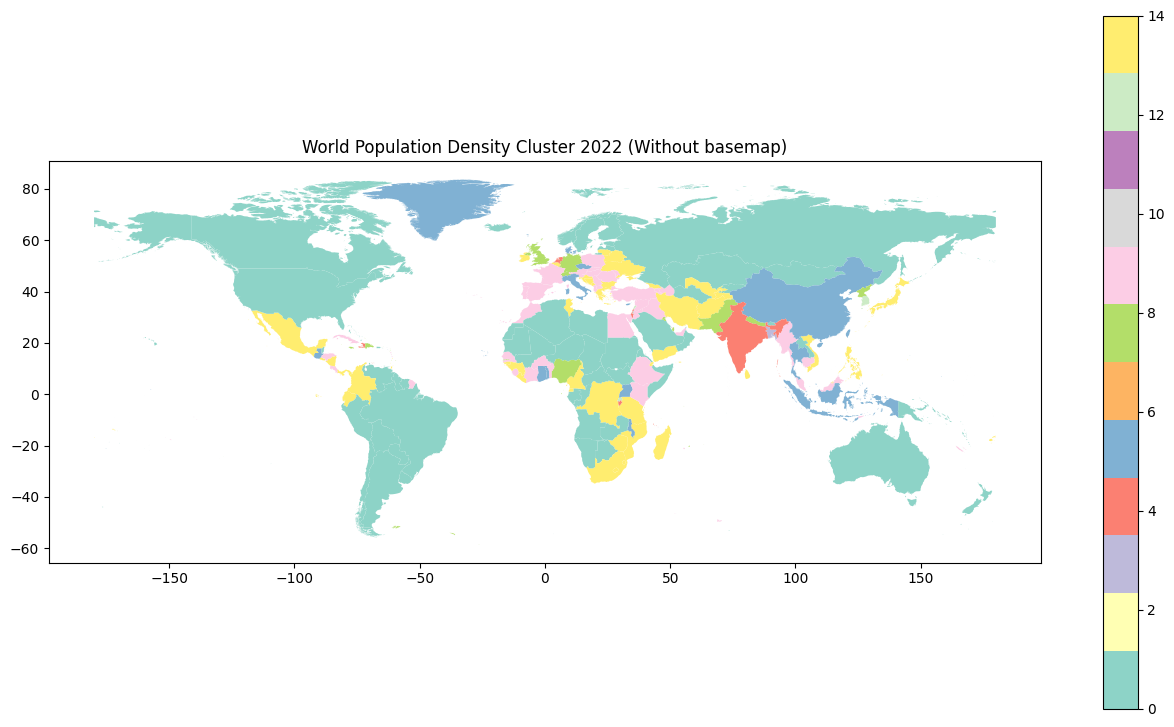

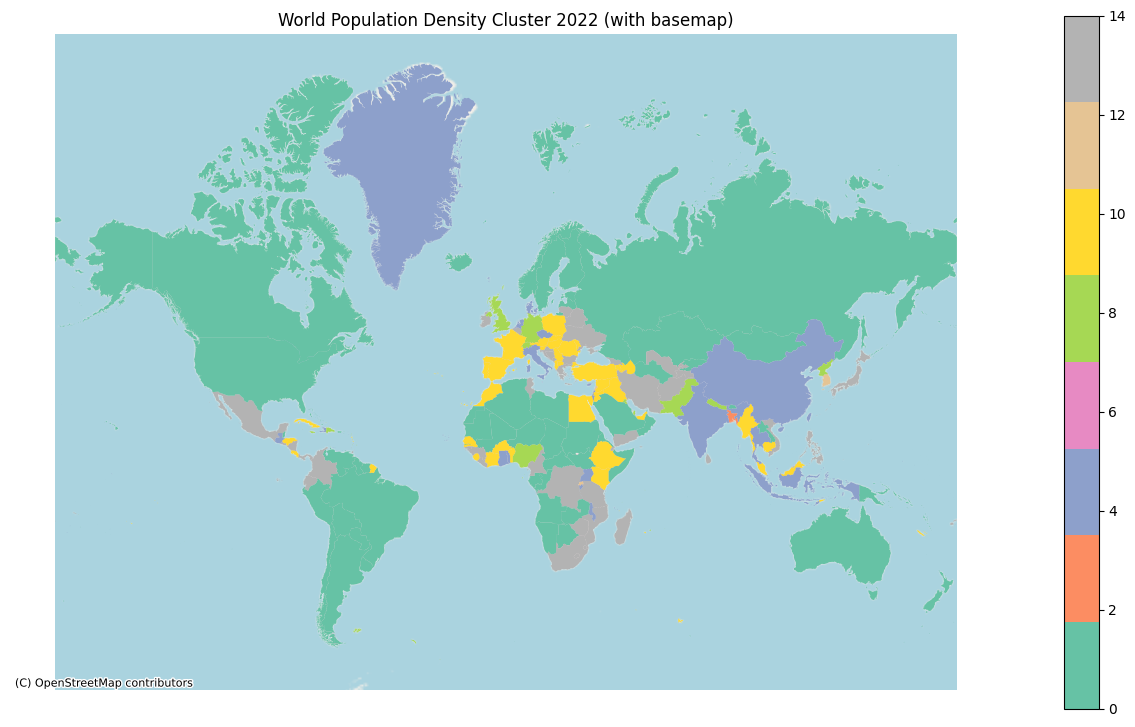

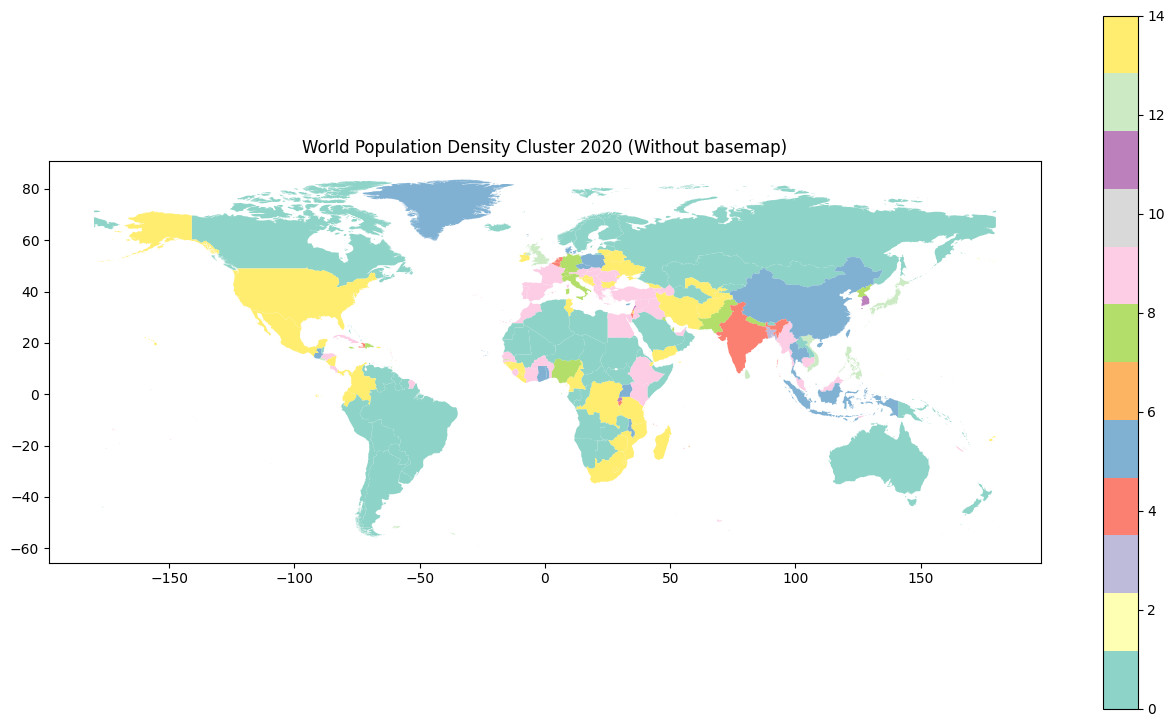

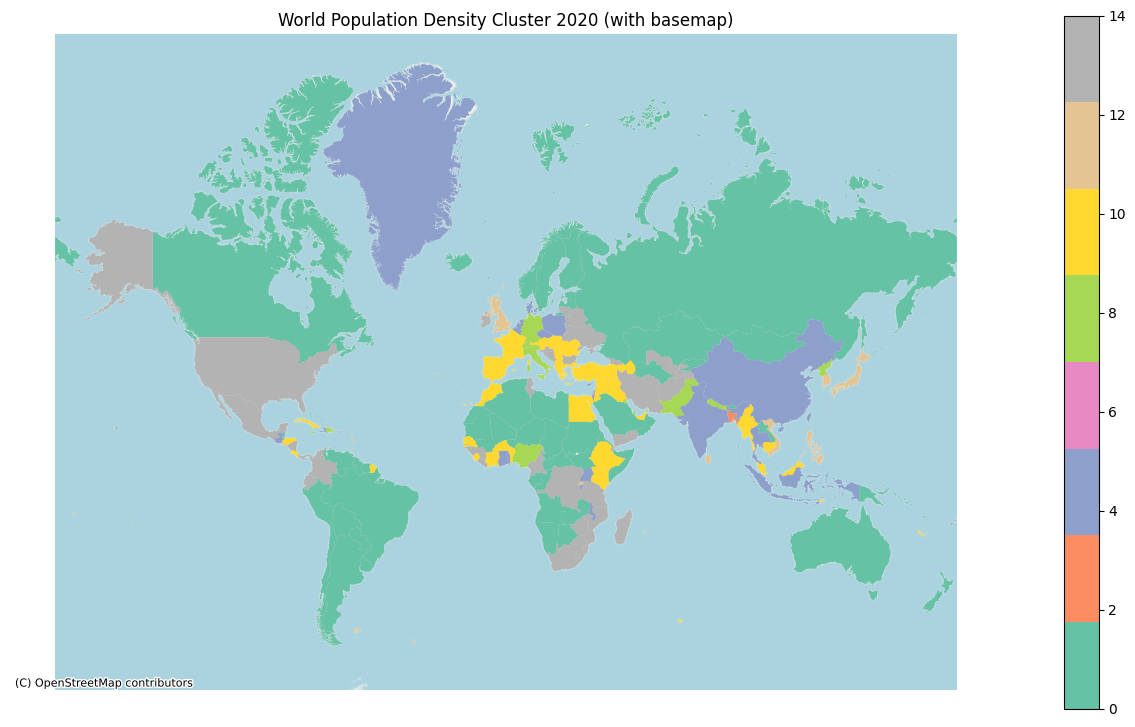

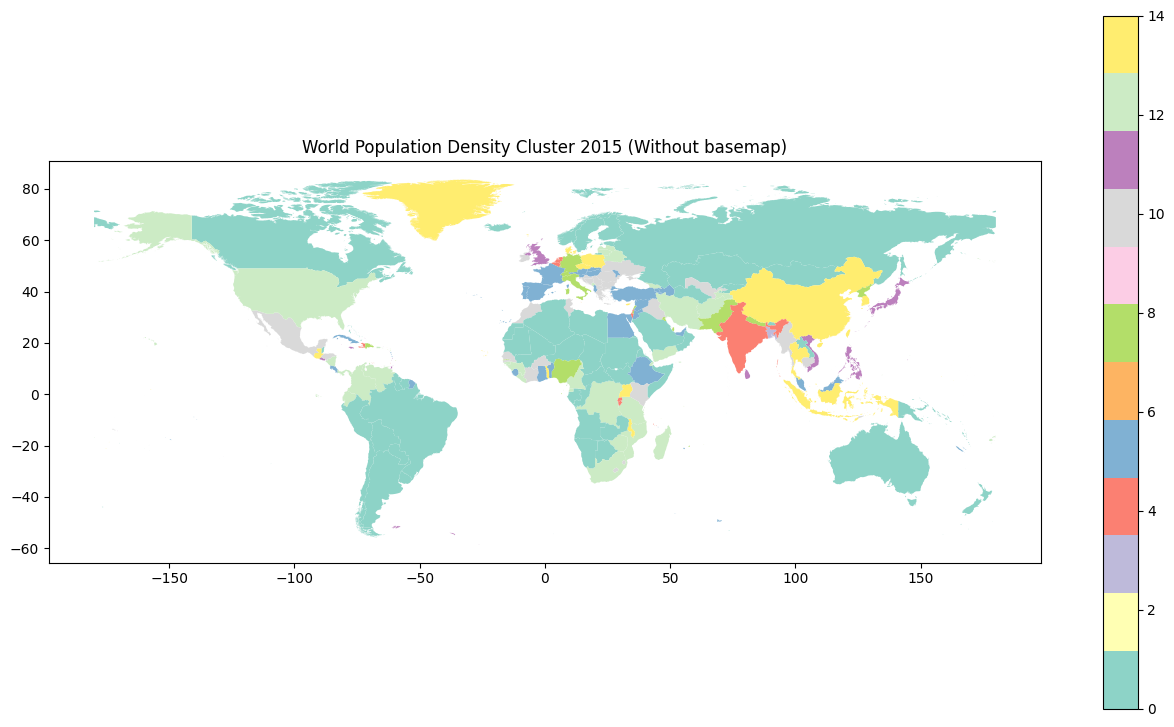

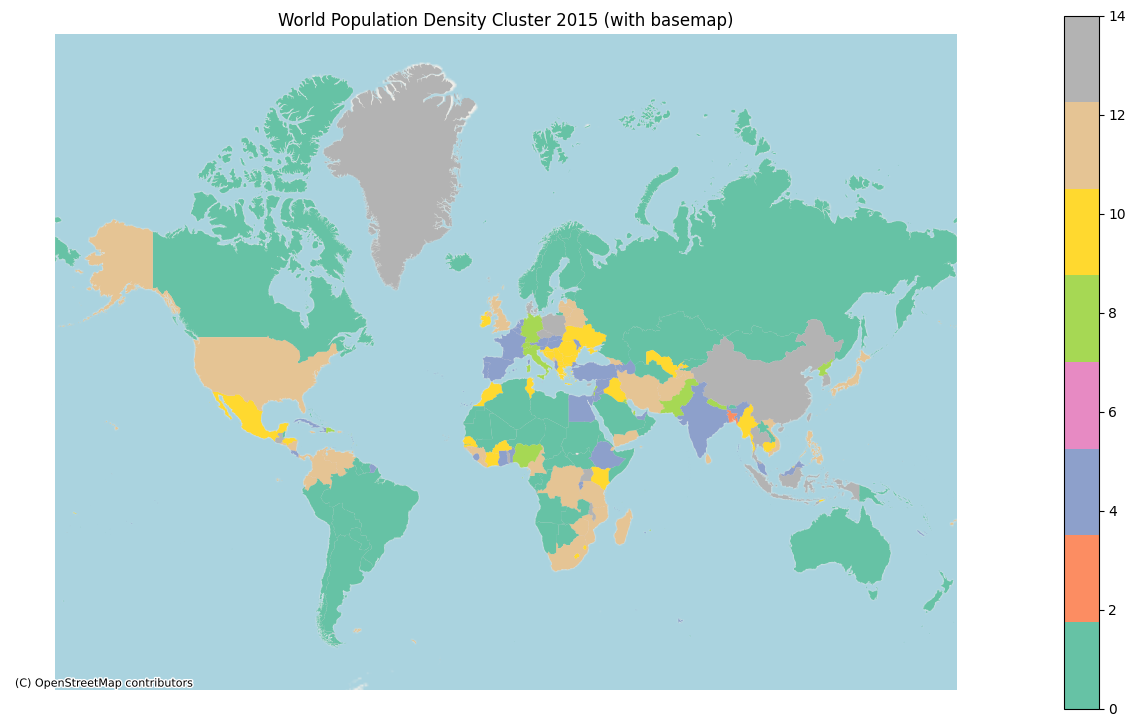

In [28]:
for y in years:
    cl_col = f"cluster_{y}" #created for loop to visualize each year withbase map and without basemap one after another


    ax = merged.plot(column=cl_col, legend=True, figsize=(16,9),cmap='Set3') #Plots the GeoDataFrame merged as a choropleth map and adds a legend
    ax.set_title(f"World Population Density Cluster {y} (Without basemap)") #Sets the title of the map,showing the year
    ax.axis("on") #adds xy axis
    plt.show() #Displays the plotted map


    merged_3857 = merged.to_crs(epsg=3857) # this is a crucial step to add a base map.This reprojects the GeoDataFrame to web mercator required for overlaying a basemap, OpenStreetMap.
    ax = merged_3857.plot(column=cl_col, legend=True, figsize=(16,9),cmap='Set2')
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"World Population Density Cluster {y} (with basemap)")
    ax.axis("on")
    plt.show() # rest of these lines are same as above


**The K-Means clustering analysis divides the world countries into 15 different communities with each community representing the similar population sizes and growth trends between 2015 and 2022. The single-country clusters which include China and India, in my opinion, represent the most massive example of it and how two countries can take over the entire world population landscape.
In the case with the mid-sized groups, including the United States, Brazil, and Indonesia, they also get included in the mix, the middle-class countries in terms of population size. At the other extreme, the small groups unite a range of medium-to-low-population countries. A good example of this is Cluster 7 which includes a lot of very small states and islands with populations of less than one million each.Most remarkable is the fact that all the clusters have growth, yet the growth rate is vastly different. The smaller and less developed countries of clusters 13 and 14 have the highest growth percentage, but the large and already populated countries have lower relative growth, but the number of cases is significant when compared to the less populated countries.
Geographically, the most extensive clusters occur in Asia and Africa with the smaller ones scattered in the islands and smaller states around the world. Overall, the map shows the wide differences in the population size and growth rates of the different regions in the world and demonstrates the obvious segregation between the mega-populated and the emerging small countries.**

In [27]:
gpkg_path = Path("/content/world_population_joined.gpkg") #Defines gpkg path
out_geojson = Path("/content/world_population_joined.geojson") #defines output path for geojson
if not gpkg_path.exists():                          #Used else if to avoid error and checked if the GeoPackage file exists
    for p in sorted(Path("/mnt/data").glob("*")):
        print(" -", p.name)                          #prints if does not exists
else:
    import fiona                                     #If the file exists, imports the fiona library to handle geospatial file
    with fiona.open(gpkg_path, layer=0) as src:      #Opens the GeoPackage file for reading
        meta = src.meta.copy()
        meta["driver"] = "GeoJSON"
        with fiona.open(out_geojson, "w", **meta) as dst:
            for feat in src:
                dst.write(feat)
    print("Converted to GeoJSON:", out_geojson)     #Creates a new GeoJSON file and writes each feature from the source GeoPackage into it.
    try:
        from google.colab import files
        files.download(str(out_geojson))
    except Exception:
        pass


Converted to GeoJSON: /content/world_population_joined.geojson


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>